In [60]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import copy
from sklearn import metrics

import lightgbm as lgb
import xgboost as xgb
import tensorly as tl


import random
import pickle
import sys
import itertools
import math
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import csv
from sklearn import preprocessing
  
from tensorly.decomposition import tucker
from tensorly import tucker_to_tensor
from tensorly.decomposition import parafac
from tensorly.decomposition import robust_pca
from sklearn import preprocessing

* Helper functions to construct tensors

In [61]:
# FOR F1 TENSOR
def get_dict_f1(path, metric="f1"):
    with open(path, "rb") as f:
        tensorDict_list = pickle.load(f)
        if metric == "f1":
            d = tensorDict_list[0]
    return d
     
     

def iter_dict_f1(tensor_dict, mode_dict, dept=0):
    for k,v in tensor_dict.items():
        if isinstance(v,dict):
            mode_dict[dept].add(k)
            iter_dict_f1(v, mode_dict, dept+1)
        else:
            mode_dict[dept].add(k)
            mode_dict[dept+1].add(v)
            
    
def get_modes_f1(tensorDict, numMode):
    # numMode + 1 since values take 1 extra level 
    modeDict = {i: set() for i in range(numMode+1)} 
    iter_dict_f1(tensorDict, modeDict)
    return modeDict
    
# assumes ordinal buckets, but there are categorical buckets: e.g ("('loc',), 'misc',",'org','per',)?)
def order_buckets_f1(d):
    d_copy = copy.deepcopy(d)
    for model in d.keys():
        for dataset in d[model].keys():
            for attribute in d[model][dataset].keys():
                d_copy[model][dataset][attribute] = {}
                for i, (k, v) in enumerate(d[model][dataset][attribute].items()):
                    d_copy[model][dataset][attribute][i] = v
    return d_copy

# for now assumes directions go as: model -> dataset -> attribute -> bucket
def get_index_f1(mode_dict):
    index_lst = []
    for m in mode_dict:
        md = dict()
        for i, n in enumerate(list(mode_dict[m])):
            md[n] = i
        index_lst.append(md)
    return index_lst


def read_dict_f1(dataDict, maplist):
    first, rest = maplist[0], maplist[1:]

    # Handle missing data
    if dataDict.get(first) == None:
        return None
    
    if rest: 
        return read_dict_f1(dataDict[first], rest)
    
    else:
        # return None if key is missing
        return dataDict.get(first) 

    
def read_tensor_f1(tensor, maplist):
    first, rest = maplist[0], maplist[1:]
    if rest: 
        return read_tensor_f1(tensor[first], rest)
    else:
        return tensor[first]
   
    
    

def write_tensor_f1(tensor, maplist, val):
    first, rest = maplist[0], maplist[1:]

    if rest: 
        assert(isinstance(tensor[first], np.ndarray))
        return write_tensor_f1(tensor[first], rest, val)
    else:
        if isinstance(tensor[first], np.ndarray):
            print("Maplist length not correct!")
        tensor[first] = val
    
    
# Construct a tensor of dimensions *argv    
def init_tensor_f1(*argv):
    size = 1
    for s in argv:
        size *= s
    X = tl.tensor(np.arange(size).reshape(argv), dtype=tl.float32)
    return X



def convert_index_f1(p, indDict):
    l = []
    for i,n in enumerate(p):
        l.append(indDict[i][n])
    return l

    
def construct_tensor_f1(modeDict, tensorDict, indexDict):
    l = []
    for _,v in modeDict.items():
        l.append(list(v))
    from_paths = list(itertools.product(*l[:-1])) # all possible entries 
    
    to_paths = []
    for p in from_paths:
        to_paths.append(convert_index(p, indexDict))

    # tensor dim
    dims = [len(modeDict[i]) for i in modeDict.keys()][:-1]
    X = init_tensor_f1(*dims)
    
    
    for p in range(len(from_paths)):
       # print(p)
        val = read_dict_f1(tensorDict, from_paths[p])
        # if data is not missing
        if val != None:
            write_tensor_f1(X,to_paths[p],val) 
        else:
            print("MISSING DATA AT "+ str(from_paths[p]))
            write_tensor_f1(X,to_paths[p],None) 
    return X
        
def all_paths_f1(modeDict):
    l = []
    for _,v in modeDict.items():
        l.append(list(v))
    p = list(itertools.product(*l[:-1])) # all possible entries 
    return p



def convert_to_df_f1(tensor, mode, index):
    all_p = all_paths_f1(mode)
    name = ["features"]
    df = pd.DataFrame(index=range(len(all_p)),columns=name)
    f1_list = []
    for i in range(len(all_p)):
       # print(str(all_p[i])[1:-1])
        paste = str(all_p[i])[1:-1]
        df.iloc[i,:]['features'] = paste
        
        
        ind = convert_index_f1(all_p[i], index)
        f1 = read_tensor_f1(tensor, ind)
        f1_list.append(f1)
    
    df[['model','dataset',"attribute","bucket"]] = df['features'].str.split(', ',expand=True)
    df = df.drop(['features'], axis=1)
    df['f1'] = f1_list
    return df

def categorize_df_f1(df, ind_lst):
    df_new = copy.deepcopy(df)
    for i in range(len(df.columns)-2):
        col_dict = ind_lst[i]
        for j in range(len(df.index)):
            entry = df.iloc[j,i]
            entry = str(entry)[1:len(entry)-1]
            val = col_dict[str(entry)]
            df_new.iloc[j,i] = val
    df_new['bucket'] = pd.to_numeric(df_new['bucket'])
    return df_new
        

def scale_f1(tensor, mode_dict, index_dict):
    all_p = all_paths_f1(mode_dict)
    paths = convert_paths(all_p,index_dict)
    tensor2 = copy.deepcopy(tensor)
    array = tensor.flatten()
    m, sd = np.mean(array), np.std(array)
    for i in paths:
        val = read_tensor_f1(tensor, i)
        transformed = (val - m) / sd
        write_tensor_f1(tensor2, i, transformed) 
    return tensor2, m, sd

def scale_back_f1(val, mean, sd):
    scale_back = val * sd + mean    
    return scale_back 

In [62]:
def train_test_split(df, fold=5):
    rows = list(range(len(df)))
    kf = KFold(n_splits=fold)
    
    test_lst = []
    train_lst = []
    for train, test in kf.split(rows):
        train_lst.append(train)
        test_lst.append(test)
        
    shuffled_df = df.sample(frac=1).reset_index(drop=True)
    
    folds = []
    for i in range(len(test_lst)):
        
        index_train = list(train_lst[i])
        index_test = list(test_lst[i])
       # print("train i", index_train)
        train = shuffled_df.iloc[index_train,:]
        test = shuffled_df.iloc[index_test,:]
        folds.append((train, test))
    return folds, shuffled_df


In [63]:
def get_modes(df, col_indices):
    numModes = len(col_indices)
    modeDict = {i: None for i in range(numModes)} 
    colInd = {j: None for j in col_indices} 
    for i in modeDict:
        c = col_indices[i]
        col = df.iloc[:,c]
        vals = pd.unique(col)
        modeDict[i] = set(vals)
        colInd[c] = i
    return modeDict, colInd

    
    modeDict = {i: None for i in col_indices} 
    for i in col_indices:
        col = df.iloc[:,i]
        vals = pd.unique(col)
        modeDict[i] = set(vals)
    return modeDict

def get_index(mode_dict):
    index_lst = []
    for m in mode_dict:
        md = dict()
        for i, n in enumerate(list(mode_dict[m])):
            md[n] = i
        index_lst.append(md)
    return index_lst


def all_paths(mode_dict):
    l = []
    for _,v in mode_dict.items():
        l.append(list(v))
    p = list(itertools.product(*l[:])) # all possible entries 
    return p


def init_tensor(modeDict):
    sl = []
    prod = 1
    for f in modeDict:
        size = len(modeDict[f])
        sl.append(size)
        prod *= size
    t = tl.zeros(sl)
    return t   

def read_tensor(tensor, maplist):
    first, rest = maplist[0], maplist[1:]
    if rest: 
        return read_tensor(tensor[first], rest)
    else:
        return tensor[first]
   


In [64]:
def scale(df, cols):
    new = df.copy()
    for i in cols:
        new.iloc[:,i] = preprocessing.scale(df.iloc[:,i])
    return new

def path_to_row(df, source='Source', target='Target'):
    path_dict = {}
    for i in range(len(df)):
        row = df.iloc[i,:]
        s, t = row[source], row[target]
        path_dict[(s,t)] = i
    return path_dict
        
def get_val(df, path, rows):
    s, t, b = path[0], path[1], path[2]
    if (s,t) in rows:
        r = rows[(s,t)]
       # print("r",r,"b",b)
        val = df.loc[r,b]
        return val
    else: return None
    
def convert_index(p, indDict):
    l = []
    for i,n in enumerate(p):
        l.append(indDict[i][n])
    return l

def write_tensor(tensor, maplist, val):
    first, rest = maplist[0], maplist[1:]

    if rest: 
        assert(isinstance(tensor[first], np.ndarray))
        return write_tensor(tensor[first], rest, val)
    else:
        if isinstance(tensor[first], np.ndarray):
            print("Maplist length not correct!")
        tensor[first] = val
    
def convert_paths(from_names, indexDict):
    to_paths = []
    for p in from_names:
        to_paths.append(convert_index(p, indexDict))
    return to_paths

    
def fill_tensor(tensor, df, path_lst, index_lst, source='Source', target='Target'):
    row_language = path_to_row(df, source=source, target=target)
    missing = []
    for p in path_lst:
        val = get_val(df, p, row_language)
        index = convert_index(p, index_lst)
        # If the path exists and value is not missing 
        
        if val != None and not math.isnan(val):
            write_tensor(tensor, index, val)
        else:
            write_tensor(tensor, index, 0)
            missing.append(p)
    return tensor, missing

                    
def create_mask(missing, tensor):
    shape = tensor.shape
    mask = tl.ones(shape, dtype=tl.float32)
    for r in missing:
        write_tensor(mask, r,0)
    return mask



In [66]:
def read_val(ind_list, tensor, s, t, f):
    s, t, f = ind_list[0][s], ind_list[1][t], ind_list[2][f]
    return tensor[s][t][f]

def transform(orig_col, val):
    m, sd = orig_col.mean(), orig_col.std()
   # print("m", m)
  #  print("sd,", sd)
    orig = val * sd + m
    return orig

In [68]:
def sample_paths(paths, size=10):
    res = []
    parts = len(paths) // size
    remain = len(paths) - parts * size
    seq = list(range(0,len(paths)))
    for i in range(parts):
        rm = random.sample(seq, k=size)
        seq = [x for x in seq if x not in rm]
        p = [paths[i] for i in rm]
        res.append(p)
    left = [paths[i] for i in seq]   
    if left:
        res.append(left)
    return res



In [69]:


def sample_tensor(tensor, df, modeDict, index_lst, missing,\
                  ratio=1, source='Source', target='Target',\
                 need_scale=False, feat_mode=None, predict_path=None):
    
    if need_scale:
        # Scaled version
        df = scale(df, [feat_mode])
    all_p = all_paths(modeDict)
    
    # randomly choose a proportion of the original dataset
    sub_df = df.sample(frac=ratio, axis=0)
    
    # sample with replacement on the smaller dataframe
    df2 = sub_df.sample(frac=1, replace=True, axis=0)
     
        
    # leave the BLEU entries blank for sanple df2
    to_rm, missing2 = [], []
    for index, row in df2.iterrows():
        s, t = row[source], row[target]
        to_rm.append((s,t, 'BLEU'))
    
    if predict_path not in to_rm:
        to_rm.append(predict_path)
        
    to_rm_ind = convert_paths(to_rm, index_lst)
    #print(to_rm)
    samp_tensor = copy.deepcopy(tensor)
    for r in to_rm_ind:
        write_tensor(samp_tensor, r, 0)
    missing2 = to_rm + missing    
    return samp_tensor, missing2
     # feat_mode=list(range(2,len(wiki.columns)))
    
    
def mask_and_recover(tensor, df,index_lst, sampled_tensor, sample_missing, predict_path=None,\
                    reg_E=1, reg_J=1, scale_back=False):
    missing_ind = convert_paths(sample_missing, index_lst)
    mask = create_mask(missing_ind, tensor)
    masked_tensor = sampled_tensor * mask
    pca_res = robust_pca(masked_tensor, mask=mask, reg_E=reg_E, reg_J=reg_J)
    pca_reconstructed = pca_res[0]
    pred_ind = convert_index(predict_path, index_lst)
    pred = read_tensor(pca_reconstructed, pred_ind)
    true = read_tensor(tensor, pred_ind)

    if scale_back:
        pred = transform(df.loc[:,'BLEU'], pred)
        true = transform(df.loc[:,'BLEU'], true)

    return pred




In [70]:
def sample_df(df, ratio=0.9, drop=True):
    
    # randomly choose a proportion of the original dataset
    sub_df = df.sample(frac=ratio, axis=0)
    
    # sample with replacement on the smaller dataframe
    df2 = sub_df.sample(frac=1, replace=True, axis=0)
    if drop:
        df2 = df2.reset_index(drop=True)
    return df2




def xgboost_bootstrap(df, num_row_lst, sampled_lst, ratio=0.9, num_iter=100, task='MT', model='xgb'): 
    complete_pred_row_lst = []
    # get test set
    for n in num_row_lst:
        comp_row = df.iloc[n,:]
        
        if task == 'MT' or task == 'tsf' or task == 'tsfmt':
            predict_row = pd.DataFrame(comp_row[3:]).T
            
        if task == 'NER':
            predict_row = pd.DataFrame(comp_row[1:5]).T
            
        predict_df = predict_row.apply(pd.to_numeric)
        complete_pred_row_lst.append(predict_df)

        
    rows_dict = {n:[] for n in num_row_lst}
    boot_distr = []
    
    for b in range(num_iter):
        rm_dup = []
        sampled_df = sampled_lst[b].copy(deep=True)
        for r in num_row_lst:
            if r in sampled_df.index:
                rm_dup.append(r)
  
        sampled_df = sampled_df.drop(rm_dup, axis=0)
        if task == 'NER':
            y = sampled_df.loc[:,'f1']
            X = sampled_df.iloc[:,1:5]
            
        if task == 'MT' or task == 'tsfmt':
            y = sampled_df.loc[:,'BLEU']
            X = sampled_df.iloc[:,3:]
            
        if task == 'tsf':
            y = sampled_df.loc[:,'Accuracy']
            X = sampled_df.iloc[:,3:]
            
        # baseline
        if model == 'base':
            train_y_mean = np.mean(y)
            for i in range(len(num_row_lst)):
                predict_row = complete_pred_row_lst[i]
                pred_y = train_y_mean
                nrow = num_row_lst[i]
                rows_dict[nrow].append(pred_y)
            

        
        # LGBM
        if model == 'lgbm':
            lg = lgb.LGBMRegressor(objective='regression_l1', num_leaves=120, learning_rate=0.08, \
                                   n_estimators=30, max_depth = 5)
            lg.fit(X, y, verbose=False)
            for i in range(len(num_row_lst)):
                predict_row = complete_pred_row_lst[i]
                pred_y = lg.predict(predict_row)
                nrow = num_row_lst[i]
                rows_dict[nrow].append(pred_y[0])
            

        # XGBoost
        if model == 'xgb':   
            reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.1,
                                      max_depth=10, n_estimators=100)
            boot_mod = reg.fit(X, y)
            for i in range(len(num_row_lst)):
                predict_row = complete_pred_row_lst[i]
                pred_y = boot_mod.predict(predict_row)
                #gp
                #pred_y = gpr.predict(predict_row)
                nrow = num_row_lst[i]
                rows_dict[nrow].append(pred_y[0])
    return rows_dict




def bootstrap_reconstruct(df, size=15, first=30, ratio=0.9, num_iter=100, task="MT",model='xgb'):
    partition = sample_paths(range(len(df)),size=size) # row nums
    part = partition[:first]
    picked_paths = {}
    all_sampled_lst = []
    for b in range(num_iter):
        boot_df = sample_df(df, ratio=ratio, drop=False)
        all_sampled_lst.append(boot_df)

    for i in range(len(part)):
        print(i)
        p = part[i]
       # xgboost_bootstrap
        boot_val_dict = xgboost_bootstrap(df, p, all_sampled_lst, ratio=ratio, num_iter=num_iter, task=task, model=model)
        picked_paths = {**picked_paths, **boot_val_dict}
        
    return picked_paths


def get_CI(a, level):
    l = (1 - level)/2
    h = 1 - l
    array = np.array(sorted(a))
   # return sorted_boot
    lo = np.quantile(array, l)
    hi = np.quantile(array, h)
    return (lo, hi)

 
def get_xy(boot_dict_pred, df, step=0.1, task="MT"):
    
    thetas = {}
    for n in boot_dict_pred.keys():
        if task == 'tsf':
            theta = df.loc[n, 'Accuracy']
        
        if task == "MT" or task == 'tsfmt':
            theta = df.loc[n, 'BLEU']
            
        if task == 'NER':
            theta = df.loc[n, 'f1']
        thetas[n] = theta
        
    
    xVals = np.arange(0,1+step,step) # increasing confidence levels
    yVals = []
    r = []
    for i in xVals:
        # get quantiles for each bucket
        count = 0
        for p in boot_dict_pred.keys():
            theta, distr = thetas[p], boot_dict_pred[p]
       
            lo, hi = get_CI(distr, i)
            r.append((lo,hi))
            # check sample line falls into interval
            if theta >= lo and theta <= hi:
                count += 1
        prop = count / len(thetas) 
        yVals.append(prop)
    return xVals, yVals,r
            

def calculate_avgwidth(distr):
    means = []
    for v in distr.keys():
        mean = np.mean(distr[v])
        means.append(mean)
    return means



### Example 1: Calibration analysis for Performance Prediction on TSFMT task with XGBoost model


In [71]:
# Read in tsf data
with open("data/dict_file_tsfmt.pkl", "rb") as f:
    tsfmt = pickle.load(f)
    
X_tsfmt = tsfmt['BLEU']['feats']
y_tsfmt = tsfmt['BLEU']['labels']
langs_tsfmt = tsfmt['BLEU']['langs']
# Obtain a complete dataframe
tsfmt = pd.concat([langs_tsfmt, y_tsfmt, X_tsfmt], axis=1)
tsfmt = tsfmt.drop(columns=['Target lang'])


In [73]:
xgb_boot_tsfmt = bootstrap_reconstruct(tsfmt, size=477, first=10, ratio=0.9, num_iter=100,task='tsfmt', model='xgb')

In [78]:
xv_tsfmt_xgb, yv_tsfmt_xgb, _ = get_xy(xgb_boot_tsfmt, tsfmt, step=0.05,task='tsfmt')

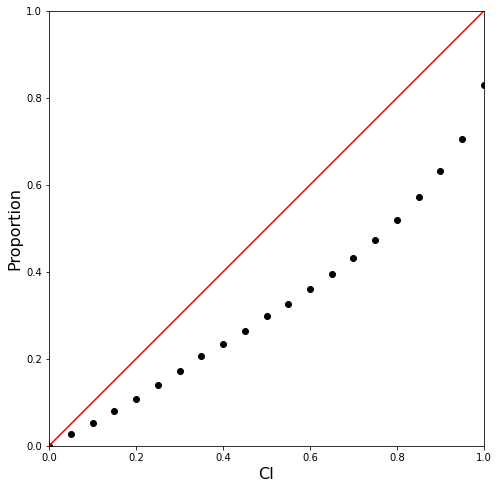

In [412]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(xv_tsfmt_xgb, yv_tsfmt_xgb, c='black')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlabel('CI', fontsize=16)
plt.ylabel('Proportion', fontsize=16)

plt.show()

In [441]:
diag = np.linspace(0,1,len(yv_tsfmt_xgb))
ECE = sum(abs(yv_tsfmt_xgb-diag))
# Expected Calibration Error
ECE
# Avg width 
np.mean(calculate_avgwidth(lgbm_boot_tsfmt))

21.412672016686834

### Example 2: Calibration analysis for Performance Prediction on TSFMT task with LGBM model

In [74]:
lgbm_boot_tsfmt = bootstrap_reconstruct(tsfmt, size=477, first=10, ratio=0.9, num_iter=100,task='tsfmt',model='lgbm')

In [77]:
xv_tsfmt_lg, yv_tsfmt_lg, _ = get_xy(lgbm_boot_tsfmt, tsfmt, step=0.05,task='tsfmt')

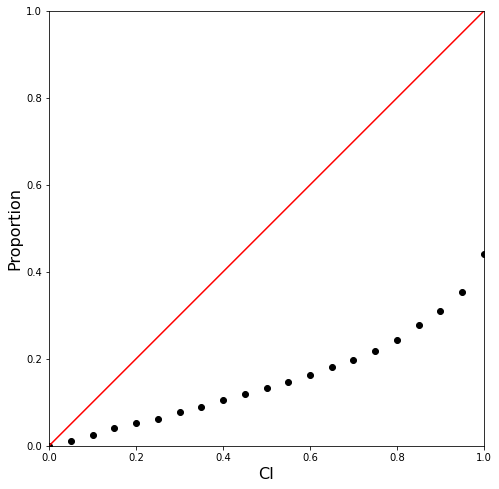

In [420]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(xv_tsfmt_lg, yv_tsfmt_lg, c='black')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlabel('CI', fontsize=16)
plt.ylabel('Proportion', fontsize=16)

plt.show()

In [76]:
diag = np.linspace(0,1,len(yv_tsfmt_lg))
ECE = sum(abs(yv_tsfmt_lg-diag))
ECE
np.mean(calculate_avgwidth(lgbm_boot_tsfmt))